# 0. Import packages and set up correct path

In [1434]:
# on Docker/local
import sys
sys.path.append("../src")
sys.path.append("../DASstore") 
sys.path.append("/home/jmanos/notebooks/whidbey_noise")

import os
import time
from datetime import datetime, timedelta

import h5py
import numpy as np
import DAS_module
import matplotlib.pyplot as plt
from tqdm import tqdm
import dasquakes
from dasquakes import das_downloader

import importlib
importlib.reload(dasquakes)

import scipy
import scipy.signal
import seis_feature
import pandas as pd
import pickle

# 1. Get data that we want

In [2328]:
cab = 'whidbey'
this_id = None
event_df = None
t0 = datetime(2022, 9, 19, 11, 0, 0)
record_length = 10


data, times, attrs, x_max, this_id, data_filt, t0 = das_downloader(event_df, this_id, cab, t0 = t0, record_length = record_length)

/data/data5/Converted/whidbey_2022-09-19_11-00*.h5
/data/data5/Converted/whidbey_2022-09-19_11-01*.h5
/data/data5/Converted/whidbey_2022-09-19_11-02*.h5
/data/data5/Converted/whidbey_2022-09-19_11-03*.h5
/data/data5/Converted/whidbey_2022-09-19_11-04*.h5
/data/data5/Converted/whidbey_2022-09-19_11-05*.h5
/data/data5/Converted/whidbey_2022-09-19_11-06*.h5
/data/data5/Converted/whidbey_2022-09-19_11-07*.h5
/data/data5/Converted/whidbey_2022-09-19_11-08*.h5
/data/data5/Converted/whidbey_2022-09-19_11-09*.h5


# 1.1 Slice the data how want to just choose specific channels

In [2329]:
# start and end channel index for the sub-array
# cha1, cha2 = 0, attrs[ 'NumberOfLoci'] #all channels
cha1, cha2 = 1100, 1600 #all channels
cha_spacing = attrs['SpatialSamplingInterval']

# 1.2 Plot the results

<IPython.core.display.Javascript object>


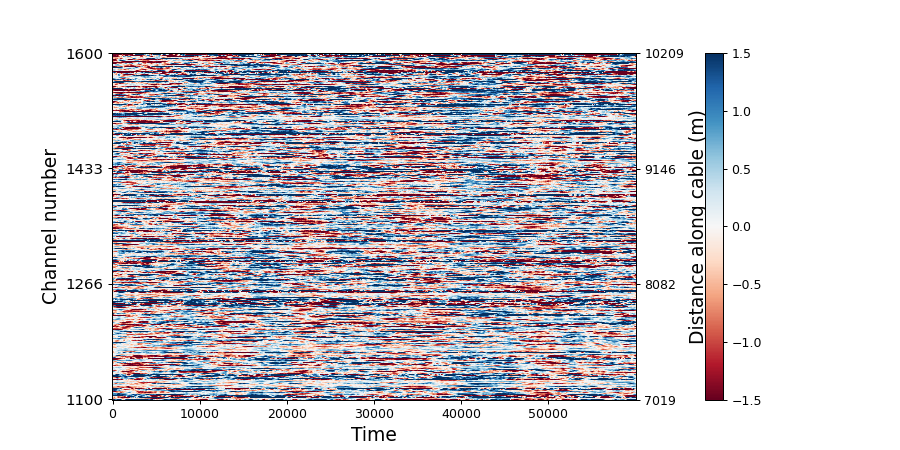

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  if sys.path[0] == "":


In [2330]:
plt.figure(figsize = (10, 5), dpi = 100)
plt.imshow(data[:,cha1:cha2].T, aspect = 'auto', 
           cmap = 'RdBu', vmax = 1.5, vmin = -1.5, origin='lower')
_ =plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
plt.ylabel("Channel number", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
twiny = plt.gca().twinx()
twiny.set_yticks(np.linspace(0, cha2 - cha1, 4), 
                             [int(i* cha_spacing) for i in np.linspace(cha1, cha2, 4)])
twiny.set_ylabel("Distance along cable (m)", fontsize = 15)
plt.colorbar(pad = 0.1)

# 2. Pre-processing

# 2.1 define parameters

In [2325]:
sps       = attrs['PulseRate']  # current sampling rate
samp_freq = 50                  # targeted sampling rate
freqmin   = 1                   # pre filtering frequency bandwidth
freqmax   = 20                  # note this cannot exceed Nquist freq

freq_norm   = 'rma'             # 'no' for no whitening, or 'rma' for running-mean average, 'phase_only' for sign-bit normalization in freq domain.
time_norm   = 'one_bit'         # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain
cc_method   = 'xcorr'           # 'xcorr' for pure cross correlation, 'deconv' for deconvolution; FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"
smooth_N    = 100               # moving window length for time domain normalization if selected (points)
smoothspect_N  = 100            # moving window length to smooth spectrum amplitude (points)
maxlag      = 8                 # lags of cross-correlation to save (sec)

# criteria for data selection
max_over_std = 10               # threahold to remove window of bad signals: set it to 10*9 if prefer not to remove them

cc_len = 60*record_length       # correlate length in second
step   = 60                     # stepping length in second

cha_list = np.array(range(cha1, cha2)) 
nsta = len(cha_list)
n_pair = int((nsta+1)*nsta/2)
n_lag = maxlag * samp_freq * 2 + 1

prepro_para = {'freqmin':freqmin,
               'freqmax':freqmax,
               'sps':sps,
               'npts_chunk':cc_len*sps,
               'nsta':nsta,
               'cha_list':cha_list,
               'samp_freq':samp_freq,
               'freq_norm':freq_norm,
               'time_norm':time_norm,
               'cc_method':cc_method,
               'smooth_N':smooth_N,
               'smoothspect_N':smoothspect_N,
               'maxlag':maxlag,
               'max_over_std':max_over_std}

# # you can save this parameter file to local
# metadata = os.path.join(CCFDIR, 'prepro_fft_info.txt')
# # output parameter info
# fout = open(metadata,'w')
# fout.write(str(prepro_para));fout.close()

In [2326]:
trace_stdS, dataS = DAS_module.preprocess_raw_make_stat(data[:,cha1:cha2], prepro_para)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<IPython.core.display.Javascript object>


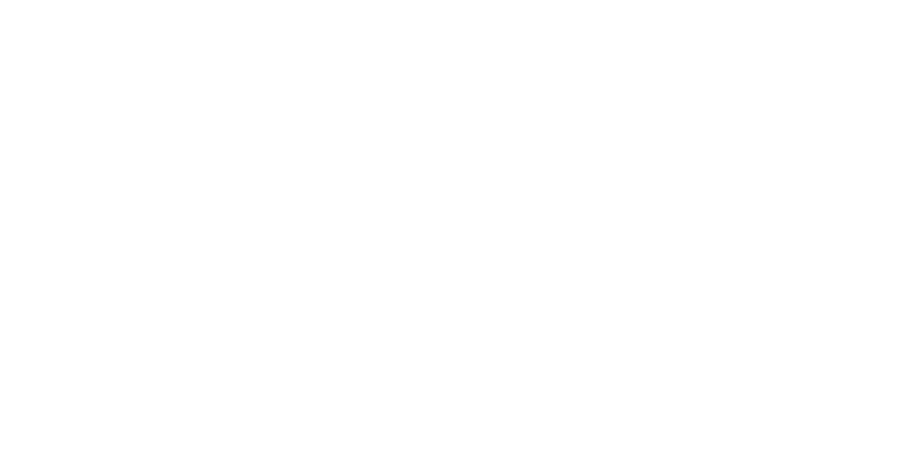

NameError: name 'dataS' is not defined

In [2327]:
plt.figure(figsize = (10, 5), dpi = 100)
plt.imshow(dataS, aspect = 'auto', 
           cmap = 'RdBu', vmax = .001, vmin = -.01, origin='lower')
_ =plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
plt.ylabel("Channel number", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
twiny = plt.gca().twinx()
twiny.set_yticks(np.linspace(0, cha2 - cha1, 4), 
                             [int(i* cha_spacing) for i in np.linspace(cha1, cha2, 4)])
twiny.set_ylabel("Distance along cable (m)", fontsize = 15)
plt.colorbar(pad = 0.1)

# 2.1 FFT, temporal and frequency normalization

In [8]:
white_spect = DAS_module.noise_processing(dataS, prepro_para)
Nfft = white_spect.shape[1]; Nfft2 = Nfft // 2
data = white_spect[:, :Nfft2]
del dataS, white_spect

print(data.shape, data.dtype)

(450, 7500) complex64


# 2.2 Channel-pair selection

In [9]:
ind = np.where((trace_stdS < prepro_para['max_over_std']) &
                        (trace_stdS > 0) &
                (np.isnan(trace_stdS) == 0))[0]
if not len(ind):
    raise ValueError('the max_over_std criteria is too high which results in no data')
sta = cha_list[ind]
white_spect = data[ind]

print(white_spect.shape, white_spect.dtype)

(153, 7500) complex64


# 2.3 Cross-correlation over all channel pairs

In [10]:
# loop over all stations
for iiS in range(len(sta)):
    # smooth the source spectrum
    sfft1 = DAS_module.smooth_source_spect(white_spect[iiS], prepro_para)

    # correlate one source with all receivers
    corr, tindx = DAS_module.correlate(sfft1, white_spect[iiS:], prepro_para, Nfft)
    
    print(f"source channel index: {sta[iiS]}, correlation shape: {corr.shape}")

source channel index: 1202, correlation shape: (153, 801)
source channel index: 1203, correlation shape: (152, 801)
source channel index: 1204, correlation shape: (151, 801)
source channel index: 1205, correlation shape: (150, 801)
source channel index: 1207, correlation shape: (149, 801)
source channel index: 1220, correlation shape: (148, 801)
source channel index: 1221, correlation shape: (147, 801)
source channel index: 1225, correlation shape: (146, 801)
source channel index: 1226, correlation shape: (145, 801)
source channel index: 1245, correlation shape: (144, 801)
source channel index: 1257, correlation shape: (143, 801)
source channel index: 1258, correlation shape: (142, 801)
source channel index: 1259, correlation shape: (141, 801)
source channel index: 1260, correlation shape: (140, 801)
source channel index: 1264, correlation shape: (139, 801)
source channel index: 1266, correlation shape: (138, 801)
source channel index: 1267, correlation shape: (137, 801)
source channel

# 3 10-minute linear stacking
We create this `corr_full` and `stack_full` matrix to store a sub-stacking results. More specifically, we linearly stack each minute of correlation in memory, and only save the hourly stacking to the CCF storage (local ASDF, S3, etc.)

In [1445]:
task_t0 = datetime(2022, 12, 1, 2, 0, 0)

n_minute = 120
record_length = 1

cab = 'whidbey'
this_id = None
event_df = None

data, times, attrs, x_max, this_id, data_filt, t0 = das_downloader(event_df, this_id, cab, t0 = task_t0, record_length = 1)

/data/data6/whidbey/whidbey_2022-12-01_02-00*.h5


We loop over all data chunk. Reminder that the data is on the cloud, and computing is made on this server. So we are downloading the data as we compute at the same time (async option?)

# 3.1 Cross-correlation

In [1446]:
#Assign the parameters
cha1, cha2 = 1150, 1550        #where to slice the cable

sps       = attrs['PulseRate']  # current sampling rate
samp_freq = 50                  # targeted sampling rate
freqmin   = 1                   # pre filtering frequency bandwidth
freqmax   = 20                  # note this cannot exceed Nquist freq

freq_norm   = 'rma'             # 'no' for no whitening, or 'rma' for running-mean average, 'phase_only' for sign-bit normalization in freq domain.
time_norm   = 'one_bit'         # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain
cc_method   = 'xcorr'           # 'xcorr' for pure cross correlation, 'deconv' for deconvolution; FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"
smooth_N    = 100               # moving window length for time domain normalization if selected (points)
smoothspect_N  = 100            # moving window length to smooth spectrum amplitude (points)
maxlag      = 8                 # lags of cross-correlation to save (sec)

# criteria for data selection
max_over_std = 100              # threahold to remove window of bad signals: set it to 10*9 if prefer not to remove them

cc_len = 60                     # correlate length in second
step   = 60                     # stepping length in second

cha_list = np.array(range(cha1, cha2)) 
nsta = len(cha_list)
n_pair = int((nsta+1)*nsta/2)
n_lag = maxlag * samp_freq * 2 + 1

prepro_para = {'freqmin':freqmin,
               'freqmax':freqmax,
               'sps':sps,
               'npts_chunk':cc_len*sps,
               'nsta':nsta,
               'cha_list':cha_list,
               'samp_freq':samp_freq,
               'freq_norm':freq_norm,
               'time_norm':time_norm,
               'cc_method':cc_method,
               'smooth_N':smooth_N,
               'smoothspect_N':smoothspect_N,
               'maxlag':maxlag,
               'max_over_std':max_over_std}

# # you can save this parameter file to local
# metadata = os.path.join(CCFDIR, 'prepro_fft_info.txt')
# # output parameter info
# fout = open(metadata,'w')
# fout.write(str(prepro_para));fout.close()

In [1447]:
corr_full = np.zeros([n_lag, n_pair], dtype = np.float32)
stack_full = np.zeros([1, n_pair], dtype = np.int32)

# each task is one minute
pbar = tqdm(range(n_minute))
t_query = 0; t_compute = 0
for imin in pbar:
    t0 = time.time()
    pbar.set_description(f"Processing {task_t0}")
    task_t0 += timedelta(minutes = record_length)
    tdata, times, attrs, x_max, this_id, data_filt, t_dummy = das_downloader(None, 
                                                                       None, 
                                                                       cab, 
                                                                       t0 = task_t0, 
                                                                       record_length = record_length)
    
    
#     tdata = client.get_data(cha_list, 
#             starttime = task_t0,
#             endtime = task_t0 + timedelta(minutes = 1)).T
    t_query += time.time() - t0

    t1 = time.time()
    # perform pre-processing
    
    trace_stdS, dataS = DAS_module.preprocess_raw_make_stat(tdata[:,cha1:cha2], prepro_para)

    # do normalization if needed
    white_spect = DAS_module.noise_processing(dataS, prepro_para)
    Nfft = white_spect.shape[1]; Nfft2 = Nfft // 2
    data = white_spect[:, :Nfft2]
    del dataS, white_spect

    ind = np.where((trace_stdS < prepro_para['max_over_std']) &
                            (trace_stdS > 0) &
                    (np.isnan(trace_stdS) == 0))[0]
    if not len(ind):
        raise ValueError('the max_over_std criteria is too high which results in no data')
    sta = cha_list[ind]
    white_spect = data[ind]

    # loop over all stations
    for iiS in range(len(sta)):
        # smooth the source spectrum
        sfft1 = DAS_module.smooth_source_spect(white_spect[iiS], prepro_para)
        
        # correlate one source with all receivers
        corr, tindx = DAS_module.correlate(sfft1, white_spect[iiS:], prepro_para, Nfft)

        # update the receiver list
        tsta = sta[iiS:]
        receiver_lst = tsta[tindx]

        iS = int((cha2*2 - cha1 - sta[iiS] + 1) * (sta[iiS] - cha1) / 2)

        # stacking one minute
        corr_full[:, iS + receiver_lst - sta[iiS]] += corr.T
        stack_full[:, iS + receiver_lst - sta[iiS]] += 1
        
    t_compute += time.time() - t1
corr_full /= stack_full
print("%.3f seconds in data query, %.3f seconds in xcorr computing" % (t_query, t_compute))

Processing 2022-12-01 02:00:00:   0%|          | 0/120 [00:00<?, ?it/s]

/data/data6/whidbey/whidbey_2022-12-01_02-01*.h5


Processing 2022-12-01 02:01:00:   1%|          | 1/120 [00:09<19:26,  9.80s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-02*.h5


Processing 2022-12-01 02:02:00:   2%|▏         | 2/120 [00:19<19:05,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-03*.h5


Processing 2022-12-01 02:03:00:   2%|▎         | 3/120 [00:29<18:58,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-04*.h5


Processing 2022-12-01 02:04:00:   3%|▎         | 4/120 [00:38<18:43,  9.69s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-05*.h5


Processing 2022-12-01 02:05:00:   4%|▍         | 5/120 [00:48<18:51,  9.84s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-06*.h5


Processing 2022-12-01 02:06:00:   5%|▌         | 6/120 [00:58<18:37,  9.80s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-07*.h5


Processing 2022-12-01 02:07:00:   6%|▌         | 7/120 [01:08<18:27,  9.80s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-08*.h5


Processing 2022-12-01 02:08:00:   7%|▋         | 8/120 [01:18<18:12,  9.76s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-09*.h5


Processing 2022-12-01 02:09:00:   8%|▊         | 9/120 [01:27<18:04,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-10*.h5


Processing 2022-12-01 02:10:00:   8%|▊         | 10/120 [01:37<17:49,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-11*.h5


Processing 2022-12-01 02:11:00:   9%|▉         | 11/120 [01:47<17:41,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-12*.h5


Processing 2022-12-01 02:12:00:  10%|█         | 12/120 [01:57<17:30,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-13*.h5


Processing 2022-12-01 02:13:00:  11%|█         | 13/120 [02:06<17:24,  9.76s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-14*.h5


Processing 2022-12-01 02:14:00:  12%|█▏        | 14/120 [02:16<17:11,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-15*.h5


Processing 2022-12-01 02:15:00:  12%|█▎        | 15/120 [02:26<17:05,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-16*.h5


Processing 2022-12-01 02:16:00:  13%|█▎        | 16/120 [02:36<16:54,  9.76s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-17*.h5


Processing 2022-12-01 02:17:00:  14%|█▍        | 17/120 [02:45<16:49,  9.80s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-18*.h5


Processing 2022-12-01 02:18:00:  15%|█▌        | 18/120 [02:55<16:38,  9.79s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-19*.h5


Processing 2022-12-01 02:19:00:  16%|█▌        | 19/120 [03:05<16:30,  9.81s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-20*.h5


Processing 2022-12-01 02:20:00:  17%|█▋        | 20/120 [03:15<16:16,  9.76s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-21*.h5


Processing 2022-12-01 02:21:00:  18%|█▊        | 21/120 [03:25<16:09,  9.79s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-22*.h5


Processing 2022-12-01 02:22:00:  18%|█▊        | 22/120 [03:34<15:58,  9.78s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-23*.h5


Processing 2022-12-01 02:23:00:  19%|█▉        | 23/120 [03:44<15:47,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-24*.h5


Processing 2022-12-01 02:24:00:  20%|██        | 24/120 [03:54<15:35,  9.75s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-25*.h5


Processing 2022-12-01 02:25:00:  21%|██        | 25/120 [04:04<15:26,  9.75s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-26*.h5


Processing 2022-12-01 02:26:00:  22%|██▏       | 26/120 [04:13<15:11,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-27*.h5


Processing 2022-12-01 02:27:00:  22%|██▎       | 27/120 [04:23<15:03,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-28*.h5


Processing 2022-12-01 02:28:00:  23%|██▎       | 28/120 [04:33<14:51,  9.69s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-29*.h5


Processing 2022-12-01 02:29:00:  24%|██▍       | 29/120 [04:42<14:43,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-30*.h5


Processing 2022-12-01 02:30:00:  25%|██▌       | 30/120 [04:52<14:32,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-31*.h5


Processing 2022-12-01 02:31:00:  26%|██▌       | 31/120 [05:02<14:25,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-32*.h5


Processing 2022-12-01 02:32:00:  27%|██▋       | 32/120 [05:11<14:11,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-33*.h5


Processing 2022-12-01 02:33:00:  28%|██▊       | 33/120 [05:21<14:05,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-34*.h5


Processing 2022-12-01 02:34:00:  28%|██▊       | 34/120 [05:31<13:52,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-35*.h5


Processing 2022-12-01 02:35:00:  29%|██▉       | 35/120 [05:40<13:44,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-36*.h5


Processing 2022-12-01 02:36:00:  30%|███       | 36/120 [05:50<13:32,  9.67s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-37*.h5


Processing 2022-12-01 02:37:00:  31%|███       | 37/120 [06:00<13:22,  9.67s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-38*.h5


Processing 2022-12-01 02:38:00:  32%|███▏      | 38/120 [06:09<13:12,  9.66s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-39*.h5


Processing 2022-12-01 02:39:00:  32%|███▎      | 39/120 [06:19<13:03,  9.67s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-40*.h5


Processing 2022-12-01 02:40:00:  33%|███▎      | 40/120 [06:29<12:51,  9.64s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-41*.h5


Processing 2022-12-01 02:41:00:  34%|███▍      | 41/120 [06:38<12:45,  9.69s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-42*.h5


Processing 2022-12-01 02:42:00:  35%|███▌      | 42/120 [06:48<12:34,  9.67s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-43*.h5


Processing 2022-12-01 02:43:00:  36%|███▌      | 43/120 [06:58<12:26,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-44*.h5


Processing 2022-12-01 02:44:00:  37%|███▋      | 44/120 [07:07<12:14,  9.66s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-45*.h5


Processing 2022-12-01 02:45:00:  38%|███▊      | 45/120 [07:17<12:07,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-46*.h5


Processing 2022-12-01 02:46:00:  38%|███▊      | 46/120 [07:27<11:55,  9.67s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-47*.h5


Processing 2022-12-01 02:47:00:  39%|███▉      | 47/120 [07:37<11:46,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-48*.h5


Processing 2022-12-01 02:48:00:  40%|████      | 48/120 [07:46<11:35,  9.66s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-49*.h5


Processing 2022-12-01 02:49:00:  41%|████      | 49/120 [07:56<11:26,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-50*.h5


Processing 2022-12-01 02:50:00:  42%|████▏     | 50/120 [08:05<11:15,  9.65s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-51*.h5


Processing 2022-12-01 02:51:00:  42%|████▎     | 51/120 [08:15<11:06,  9.66s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-52*.h5


Processing 2022-12-01 02:52:00:  43%|████▎     | 52/120 [08:25<10:56,  9.65s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-53*.h5


Processing 2022-12-01 02:53:00:  44%|████▍     | 53/120 [08:35<10:49,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-54*.h5


Processing 2022-12-01 02:54:00:  45%|████▌     | 54/120 [08:44<10:39,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-55*.h5


Processing 2022-12-01 02:55:00:  46%|████▌     | 55/120 [08:54<10:30,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-56*.h5


Processing 2022-12-01 02:56:00:  47%|████▋     | 56/120 [09:04<10:20,  9.69s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-57*.h5


Processing 2022-12-01 02:57:00:  48%|████▊     | 57/120 [09:13<10:11,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-58*.h5


Processing 2022-12-01 02:58:00:  48%|████▊     | 58/120 [09:23<10:01,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-01_02-59*.h5


Processing 2022-12-01 02:59:00:  49%|████▉     | 59/120 [09:33<09:54,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-00*.h5


Processing 2022-12-01 03:00:00:  50%|█████     | 60/120 [09:43<09:43,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-01*.h5


Processing 2022-12-01 03:01:00:  51%|█████     | 61/120 [09:52<09:37,  9.78s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-02*.h5


Processing 2022-12-01 03:02:00:  52%|█████▏    | 62/120 [10:02<09:25,  9.75s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-03*.h5


Processing 2022-12-01 03:03:00:  52%|█████▎    | 63/120 [10:12<09:16,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-04*.h5


Processing 2022-12-01 03:04:00:  53%|█████▎    | 64/120 [10:22<09:04,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-05*.h5


Processing 2022-12-01 03:05:00:  54%|█████▍    | 65/120 [10:31<08:56,  9.75s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-06*.h5


Processing 2022-12-01 03:06:00:  55%|█████▌    | 66/120 [10:41<08:45,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-07*.h5


Processing 2022-12-01 03:07:00:  56%|█████▌    | 67/120 [10:51<08:37,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-08*.h5


Processing 2022-12-01 03:08:00:  57%|█████▋    | 68/120 [11:01<08:26,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-09*.h5


Processing 2022-12-01 03:09:00:  57%|█████▊    | 69/120 [11:10<08:15,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-10*.h5


Processing 2022-12-01 03:10:00:  58%|█████▊    | 70/120 [11:20<08:05,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-11*.h5


Processing 2022-12-01 03:11:00:  59%|█████▉    | 71/120 [11:30<07:58,  9.76s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-12*.h5


Processing 2022-12-01 03:12:00:  60%|██████    | 72/120 [11:40<07:46,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-13*.h5


Processing 2022-12-01 03:13:00:  61%|██████    | 73/120 [11:49<07:39,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-14*.h5


Processing 2022-12-01 03:14:00:  62%|██████▏   | 74/120 [11:59<07:27,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-15*.h5


Processing 2022-12-01 03:15:00:  62%|██████▎   | 75/120 [12:09<07:17,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-16*.h5


Processing 2022-12-01 03:16:00:  63%|██████▎   | 76/120 [12:18<07:07,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-17*.h5


Processing 2022-12-01 03:17:00:  64%|██████▍   | 77/120 [12:28<06:58,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-18*.h5


Processing 2022-12-01 03:18:00:  65%|██████▌   | 78/120 [12:38<06:48,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-19*.h5


Processing 2022-12-01 03:19:00:  66%|██████▌   | 79/120 [12:48<06:39,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-20*.h5


Processing 2022-12-01 03:20:00:  67%|██████▋   | 80/120 [12:57<06:28,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-21*.h5


Processing 2022-12-01 03:21:00:  68%|██████▊   | 81/120 [13:07<06:19,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-22*.h5


Processing 2022-12-01 03:22:00:  68%|██████▊   | 82/120 [13:17<06:08,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-23*.h5


Processing 2022-12-01 03:23:00:  69%|██████▉   | 83/120 [13:27<06:00,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-24*.h5


Processing 2022-12-01 03:24:00:  70%|███████   | 84/120 [13:36<05:50,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-25*.h5


Processing 2022-12-01 03:25:00:  71%|███████   | 85/120 [13:46<05:40,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-26*.h5


Processing 2022-12-01 03:26:00:  72%|███████▏  | 86/120 [13:56<05:29,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-27*.h5


Processing 2022-12-01 03:27:00:  72%|███████▎  | 87/120 [14:05<05:21,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-28*.h5


Processing 2022-12-01 03:28:00:  73%|███████▎  | 88/120 [14:15<05:11,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-29*.h5


Processing 2022-12-01 03:29:00:  74%|███████▍  | 89/120 [14:25<05:02,  9.75s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-30*.h5


Processing 2022-12-01 03:30:00:  75%|███████▌  | 90/120 [14:35<04:51,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-31*.h5


Processing 2022-12-01 03:31:00:  76%|███████▌  | 91/120 [14:44<04:42,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-32*.h5


Processing 2022-12-01 03:32:00:  77%|███████▋  | 92/120 [14:54<04:32,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-33*.h5


Processing 2022-12-01 03:33:00:  78%|███████▊  | 93/120 [15:04<04:23,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-34*.h5


Processing 2022-12-01 03:34:00:  78%|███████▊  | 94/120 [15:14<04:13,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-35*.h5


Processing 2022-12-01 03:35:00:  79%|███████▉  | 95/120 [15:24<04:04,  9.79s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-36*.h5


Processing 2022-12-01 03:36:00:  80%|████████  | 96/120 [15:33<03:54,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-37*.h5


Processing 2022-12-01 03:37:00:  81%|████████  | 97/120 [15:43<03:44,  9.78s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-38*.h5


Processing 2022-12-01 03:38:00:  82%|████████▏ | 98/120 [15:53<03:34,  9.75s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-39*.h5


Processing 2022-12-01 03:39:00:  82%|████████▎ | 99/120 [16:03<03:24,  9.75s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-40*.h5


Processing 2022-12-01 03:40:00:  83%|████████▎ | 100/120 [16:12<03:14,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-41*.h5


Processing 2022-12-01 03:41:00:  84%|████████▍ | 101/120 [16:22<03:04,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-42*.h5


Processing 2022-12-01 03:42:00:  85%|████████▌ | 102/120 [16:31<02:53,  9.66s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-43*.h5


Processing 2022-12-01 03:43:00:  86%|████████▌ | 103/120 [16:41<02:45,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-44*.h5


Processing 2022-12-01 03:44:00:  87%|████████▋ | 104/120 [16:51<02:34,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-45*.h5


Processing 2022-12-01 03:45:00:  88%|████████▊ | 105/120 [17:01<02:25,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-46*.h5


Processing 2022-12-01 03:46:00:  88%|████████▊ | 106/120 [17:10<02:15,  9.67s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-47*.h5


Processing 2022-12-01 03:47:00:  89%|████████▉ | 107/120 [17:20<02:05,  9.69s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-48*.h5


Processing 2022-12-01 03:48:00:  90%|█████████ | 108/120 [17:30<01:56,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-49*.h5


Processing 2022-12-01 03:49:00:  91%|█████████ | 109/120 [17:39<01:46,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-50*.h5


Processing 2022-12-01 03:50:00:  92%|█████████▏| 110/120 [17:49<01:37,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-51*.h5


Processing 2022-12-01 03:51:00:  92%|█████████▎| 111/120 [17:59<01:28,  9.78s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-52*.h5


Processing 2022-12-01 03:52:00:  93%|█████████▎| 112/120 [18:09<01:18,  9.79s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-53*.h5


Processing 2022-12-01 03:53:00:  94%|█████████▍| 113/120 [18:19<01:08,  9.81s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-54*.h5


Processing 2022-12-01 03:54:00:  95%|█████████▌| 114/120 [18:29<00:58,  9.80s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-55*.h5


Processing 2022-12-01 03:55:00:  96%|█████████▌| 115/120 [18:38<00:49,  9.84s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-56*.h5


Processing 2022-12-01 03:56:00:  97%|█████████▋| 116/120 [18:48<00:39,  9.82s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-57*.h5


Processing 2022-12-01 03:57:00:  98%|█████████▊| 117/120 [18:58<00:29,  9.87s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-58*.h5


Processing 2022-12-01 03:58:00:  98%|█████████▊| 118/120 [19:08<00:19,  9.83s/it]

/data/data6/whidbey/whidbey_2022-12-01_03-59*.h5


Processing 2022-12-01 03:59:00:  99%|█████████▉| 119/120 [19:18<00:09,  9.85s/it]

/data/data6/whidbey/whidbey_2022-12-01_04-00*.h5


Processing 2022-12-01 03:59:00: 100%|██████████| 120/120 [19:27<00:00,  9.73s/it]

176.563 seconds in data query, 991.300 seconds in xcorr computing


In [622]:
# This function will allow the moveout viewing

#     vsg = np.zeros([801, nsta])
#     source_step = 100
#     for i in range(source_step):
#         chan_source = i + cha1
#         iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
#         vsg[:, i] = corr_full[:, iS + (source_step - i)][::-1]

#     chan_source = cha1 + source_step
#     iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
#     iS2 =  int((cha2*2 - cha1 - (chan_source+1) + 1) * ((chan_source+1) - cha1) / 2)
#     vsg[:, source_step:] = corr_full[:, iS:iS2]
    

## 3.2 Save a move-out gif

<IPython.core.display.Javascript object>


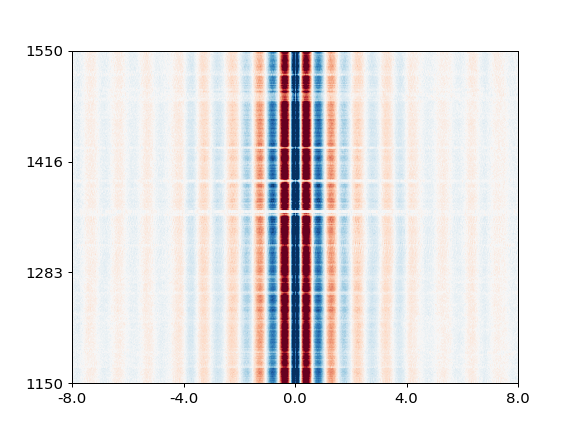

In [1450]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter


ims = []
fig = plt.figure()
for i in np.arange(0,nsta,1):
    vsg = np.zeros([801, nsta])
    source_step = i
    for i in range(source_step):
        chan_source = i + cha1
        iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
        vsg[:, i] = corr_full[:, iS + (source_step - i)][::-1]

    chan_source = cha1 + source_step
    iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
    iS2 =  int((cha2*2 - cha1 - (chan_source+1) + 1) * ((chan_source+1) - cha1) / 2)
    vsg[:, source_step:] = corr_full[:, iS:iS2]
    
    im = plt.imshow(vsg.T, aspect = 'auto', cmap = 'RdBu', 
               vmax = 5e-2, vmin = -5e-2, origin = 'lower')

    _ = plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
                  [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
    _ = plt.xticks(np.arange(0, 801, 200), (np.arange(0, 801, 200) - 400)/50, fontsize = 12)
    
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=500)

writer = PillowWriter(fps=20)
#ani.save("move_out_sept.gif", writer=writer)

plt.show()

# 3.3 Code to look at individual plots

<IPython.core.display.Javascript object>


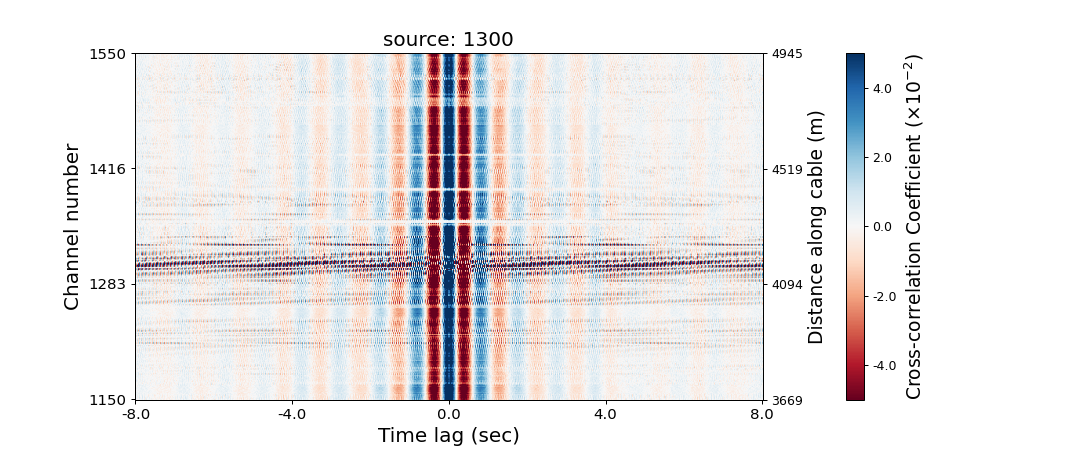

Text(0, 0.5, 'Distance along cable (m)')

In [1449]:

source_step = 150
chan_source = cha1 + source_step #choose the virtual source channel

iS = int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)

vsg = np.zeros([801, nsta])

for i in range(source_step):
    chan_source = i + cha1
    iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
    vsg[:, i] = corr_full[:, iS + (source_step - i)][::-1]

chan_source = cha1 + source_step
iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
iS2 =  int((cha2*2 - cha1 - (chan_source+1) + 1) * ((chan_source+1) - cha1) / 2)
vsg[:, source_step:] = corr_full[:, iS:iS2]

plt.figure(figsize = (12, 5), dpi = 100)

plt.imshow(vsg.T, aspect = 'auto', cmap = 'RdBu', 
           vmax = 5e-2, vmin = -5e-2, origin = 'lower')

_ =plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
_ = plt.xticks(np.arange(0, 801, 200), (np.arange(0, 801, 200) - 400)/50, fontsize = 12)
plt.ylabel("Channel number", fontsize = 16)
plt.xlabel("Time lag (sec)", fontsize = 16)
plt.title("source: " + str(chan_source), fontsize = 16)
bar = plt.colorbar(pad = 0.1, format = lambda x, pos: '{:.1f}'.format(x*100))
bar.set_label('Cross-correlation Coefficient ($\\times10^{-2}$)', fontsize = 15)

twiny = plt.gca().twinx()
twiny.set_yticks(np.linspace(0, cha2 - cha1, 4), 
                             [int(i* cha_spacing) for i in np.linspace(cha1, cha2, 4)])
twiny.set_ylabel("Distance along cable (m)", fontsize = 15)

# 4.0 2D FFT

<IPython.core.display.Javascript object>


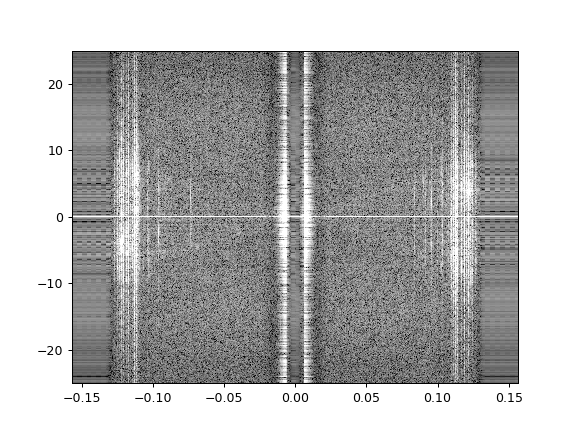

In [1451]:
from numpy.fft import fftshift, fft2, fftfreq

source_step = 212
chan_source = cha1 + source_step #choose the virtual source channel


vsg = np.zeros([801, nsta])
for i in range(source_step):
    chan_source = i + cha1
    iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
    vsg[:, i] = corr_full[:, iS + (source_step - i)][::-1]
chan_source = cha1 + source_step
iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
iS2 =  int((cha2*2 - cha1 - (chan_source+1) + 1) * ((chan_source+1) - cha1) / 2)
vsg[:, source_step:] = corr_full[:, iS:iS2]

ft = fftshift(fft2(vsg.T))
f = fftshift(fftfreq(vsg.T.shape[0], d=1/samp_freq))
k = fftshift(fftfreq(vsg.T.shape[1], d=attrs['SpatialSamplingInterval']))

fig, ax = plt.subplots()
# ax.imshow(np.real(ft), aspect = 'auto', cmap = 'RdBu', 
#            vmax = 1e0, vmin = -1e0, origin = 'lower')

ax.pcolormesh(k,f,np.log10(np.abs(ft)),vmin=-1,vmax = 1, cmap='gray')
# ax.set_ylim([200,400])
# ax.set_xlim([300,500])
plt.show()

### 4.1 Ok, stacking this now?

In [1452]:
all_ffts = []

for i in range(nsta):
    vsg = np.zeros([801, nsta])
    source_step = i
    for i in range(source_step):
        chan_source = i + cha1
        iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
        vsg[:, i] = corr_full[:, iS + (source_step - i)][::-1]

    chan_source = cha1 + source_step
    iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
    iS2 =  int((cha2*2 - cha1 - (chan_source+1) + 1) * ((chan_source+1) - cha1) / 2)
    vsg[:, source_step:] = corr_full[:, iS:iS2]
    source_step = i


    ft = fftshift(fft2(vsg.T))
    f = fftshift(fftfreq(vsg.T.shape[0], d=1/samp_freq))
    k = fftshift(fftfreq(vsg.T.shape[1], d=attrs['SpatialSamplingInterval']))
#     print(ft.shape)
    all_ffts.append(np.log10(np.abs(ft)))

<IPython.core.display.Javascript object>


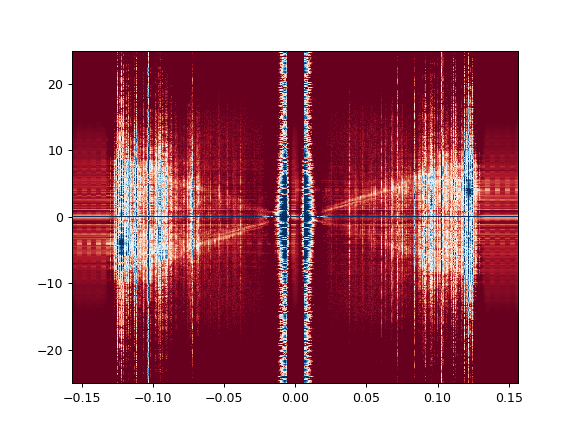

In [1453]:
d3_matrix = np.asarray(all_ffts)
stacked = np.mean(d3_matrix, axis=0)


fig, ax = plt.subplots()

ax.pcolormesh(k,f,stacked,vmin=.01,vmax =1, cmap='RdBu')
# ax.set_ylim([0,2])
# ax.set_xlim([0.006,.03])
plt.show()

In [1454]:
# Save the stacked image
# Get the start file time
file_start_time = task_t0 - timedelta(minutes=n_minute)
# Open a file and use dump()
with open('../data/stacked_fk/fk_array_'+str(file_start_time)+'_'+str(task_t0)+'.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(stacked, file)

### 4.2 Annimate the fk plot?

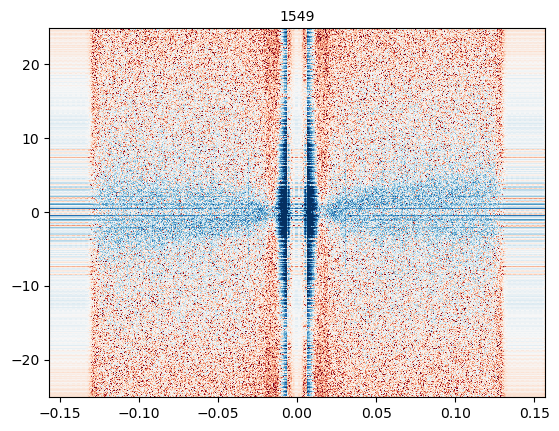

In [868]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

ims = []
fig,ax = plt.subplots()

for i in range(nsta):
    vsg = np.zeros([801, nsta])
    source_step = i
    for i in range(source_step):
        chan_source = i + cha1
        iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
        vsg[:, i] = corr_full[:, iS + (source_step - i)][::-1]

    chan_source = cha1 + source_step
    iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
    iS2 =  int((cha2*2 - cha1 - (chan_source+1) + 1) * ((chan_source+1) - cha1) / 2)
    vsg[:, source_step:] = corr_full[:, iS:iS2]
    source_step = i


    ft = fftshift(fft2(vsg.T))
    f = fftshift(fftfreq(vsg.T.shape[0], d=1/samp_freq))
    k = fftshift(fftfreq(vsg.T.shape[1], d=attrs['SpatialSamplingInterval']))
    
    
    title = plt.text(0.5, 1.01, chan_source, horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    
    im = ax.pcolormesh(k,f,np.log10(np.abs(ft)),vmin=-1,vmax = 1, cmap='RdBu')
    
    ims.append([im, title])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=500)

writer = PillowWriter(fps=20)
#ani.save("fk_all_chans_2hr.gif", writer=writer)

plt.show()




# 5.0 What about land-based cable?

In [1545]:
task_t0 = datetime(2022, 12, 27, 16, 0, 0)

n_minute = 120
record_length = 1

cab = 'whidbey'
this_id = None
event_df = None

data, times, attrs, x_max, this_id, data_filt, t0 = das_downloader(event_df, this_id, cab, t0 = task_t0, record_length = 1)

/data/data6/whidbey/whidbey_2022-12-27_16-00*.h5


In [1546]:
#Assign the parameters
cha1, cha2 = 10, 400        #where to slice the cable

sps       = attrs['PulseRate']  # current sampling rate
samp_freq = 50                  # targeted sampling rate
freqmin   = 1                   # pre filtering frequency bandwidth
freqmax   = 20                  # note this cannot exceed Nquist freq

freq_norm   = 'rma'             # 'no' for no whitening, or 'rma' for running-mean average, 'phase_only' for sign-bit normalization in freq domain.
time_norm   = 'one_bit'         # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain
cc_method   = 'xcorr'           # 'xcorr' for pure cross correlation, 'deconv' for deconvolution; FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"
smooth_N    = 100               # moving window length for time domain normalization if selected (points)
smoothspect_N  = 100            # moving window length to smooth spectrum amplitude (points)
maxlag      = 8                 # lags of cross-correlation to save (sec)

# criteria for data selection
max_over_std = 100              # threahold to remove window of bad signals: set it to 10*9 if prefer not to remove them

cc_len = 60                     # correlate length in second
step   = 60                     # stepping length in second

cha_list = np.array(range(cha1, cha2)) 
nsta = len(cha_list)
n_pair = int((nsta+1)*nsta/2)
n_lag = maxlag * samp_freq * 2 + 1

prepro_para = {'freqmin':freqmin,
               'freqmax':freqmax,
               'sps':sps,
               'npts_chunk':cc_len*sps,
               'nsta':nsta,
               'cha_list':cha_list,
               'samp_freq':samp_freq,
               'freq_norm':freq_norm,
               'time_norm':time_norm,
               'cc_method':cc_method,
               'smooth_N':smooth_N,
               'smoothspect_N':smoothspect_N,
               'maxlag':maxlag,
               'max_over_std':max_over_std}

# # you can save this parameter file to local
# metadata = os.path.join(CCFDIR, 'prepro_fft_info.txt')
# # output parameter info
# fout = open(metadata,'w')
# fout.write(str(prepro_para));fout.close()

In [1547]:
corr_full = np.zeros([n_lag, n_pair], dtype = np.float32)
stack_full = np.zeros([1, n_pair], dtype = np.int32)

# each task is one minute
pbar = tqdm(range(n_minute))
t_query = 0; t_compute = 0
for imin in pbar:
    t0 = time.time()
    pbar.set_description(f"Processing {task_t0}")
    task_t0 += timedelta(minutes = record_length)
    tdata, times, attrs, x_max, this_id, data_filt, t_dummy = das_downloader(None, 
                                                                       None, 
                                                                       cab, 
                                                                       t0 = task_t0, 
                                                                       record_length = record_length)
    
    
#     tdata = client.get_data(cha_list, 
#             starttime = task_t0,
#             endtime = task_t0 + timedelta(minutes = 1)).T
    t_query += time.time() - t0

    t1 = time.time()
    # perform pre-processing
    
    trace_stdS, dataS = DAS_module.preprocess_raw_make_stat(tdata[:,cha1:cha2], prepro_para)

    # do normalization if needed
    white_spect = DAS_module.noise_processing(dataS, prepro_para)
    Nfft = white_spect.shape[1]; Nfft2 = Nfft // 2
    data = white_spect[:, :Nfft2]
    del dataS, white_spect

    ind = np.where((trace_stdS < prepro_para['max_over_std']) &
                            (trace_stdS > 0) &
                    (np.isnan(trace_stdS) == 0))[0]
    if not len(ind):
        raise ValueError('the max_over_std criteria is too high which results in no data')
    sta = cha_list[ind]
    white_spect = data[ind]

    # loop over all stations
    for iiS in range(len(sta)):
        # smooth the source spectrum
        sfft1 = DAS_module.smooth_source_spect(white_spect[iiS], prepro_para)
        
        # correlate one source with all receivers
        corr, tindx = DAS_module.correlate(sfft1, white_spect[iiS:], prepro_para, Nfft)

        # update the receiver list
        tsta = sta[iiS:]
        receiver_lst = tsta[tindx]

        iS = int((cha2*2 - cha1 - sta[iiS] + 1) * (sta[iiS] - cha1) / 2)

        # stacking one minute
        corr_full[:, iS + receiver_lst - sta[iiS]] += corr.T
        stack_full[:, iS + receiver_lst - sta[iiS]] += 1
        
    t_compute += time.time() - t1
corr_full /= stack_full
print("%.3f seconds in data query, %.3f seconds in xcorr computing" % (t_query, t_compute))

Processing 2022-12-27 16:00:00:   0%|          | 0/120 [00:00<?, ?it/s]

/data/data6/whidbey/whidbey_2022-12-27_16-01*.h5


Processing 2022-12-27 16:01:00:   1%|          | 1/120 [00:09<19:20,  9.76s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-02*.h5


Processing 2022-12-27 16:02:00:   2%|▏         | 2/120 [00:19<19:13,  9.78s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-03*.h5


Processing 2022-12-27 16:03:00:   2%|▎         | 3/120 [00:29<19:02,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-04*.h5


Processing 2022-12-27 16:04:00:   3%|▎         | 4/120 [00:39<18:51,  9.76s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-05*.h5


Processing 2022-12-27 16:05:00:   4%|▍         | 5/120 [00:48<18:44,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-06*.h5


Processing 2022-12-27 16:06:00:   5%|▌         | 6/120 [00:58<18:33,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-07*.h5


Processing 2022-12-27 16:07:00:   6%|▌         | 7/120 [01:08<18:25,  9.79s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-08*.h5


Processing 2022-12-27 16:08:00:   7%|▋         | 8/120 [01:18<18:18,  9.81s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-09*.h5


Processing 2022-12-27 16:09:00:   8%|▊         | 9/120 [01:28<18:07,  9.80s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-10*.h5


Processing 2022-12-27 16:10:00:   8%|▊         | 10/120 [01:37<17:56,  9.79s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-11*.h5


Processing 2022-12-27 16:11:00:   9%|▉         | 11/120 [01:47<17:48,  9.80s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-12*.h5


Processing 2022-12-27 16:12:00:  10%|█         | 12/120 [01:57<17:36,  9.78s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-13*.h5


Processing 2022-12-27 16:13:00:  11%|█         | 13/120 [02:07<17:25,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-14*.h5


Processing 2022-12-27 16:14:00:  12%|█▏        | 14/120 [02:16<17:16,  9.78s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-15*.h5


Processing 2022-12-27 16:15:00:  12%|█▎        | 15/120 [02:26<17:06,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-16*.h5


Processing 2022-12-27 16:16:00:  13%|█▎        | 16/120 [02:36<16:55,  9.76s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-17*.h5


Processing 2022-12-27 16:17:00:  14%|█▍        | 17/120 [02:46<16:47,  9.78s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-18*.h5


Processing 2022-12-27 16:18:00:  15%|█▌        | 18/120 [02:56<16:44,  9.85s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-19*.h5


Processing 2022-12-27 16:19:00:  16%|█▌        | 19/120 [03:06<16:33,  9.83s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-20*.h5


Processing 2022-12-27 16:20:00:  17%|█▋        | 20/120 [03:16<16:35,  9.95s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-21*.h5


Processing 2022-12-27 16:21:00:  18%|█▊        | 21/120 [08:51<2:57:38, 107.66s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-22*.h5


Processing 2022-12-27 16:22:00:  18%|█▊        | 22/120 [09:02<2:08:11, 78.49s/it] 

/data/data6/whidbey/whidbey_2022-12-27_16-23*.h5


Processing 2022-12-27 16:23:00:  19%|█▉        | 23/120 [09:11<1:33:30, 57.84s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-24*.h5


Processing 2022-12-27 16:24:00:  20%|██        | 24/120 [09:21<1:09:22, 43.36s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-25*.h5


Processing 2022-12-27 16:25:00:  21%|██        | 25/120 [09:31<52:37, 33.24s/it]  

/data/data6/whidbey/whidbey_2022-12-27_16-26*.h5


Processing 2022-12-27 16:26:00:  22%|██▏       | 26/120 [09:40<40:57, 26.15s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-27*.h5


Processing 2022-12-27 16:27:00:  22%|██▎       | 27/120 [09:50<32:49, 21.17s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-28*.h5


Processing 2022-12-27 16:28:00:  23%|██▎       | 28/120 [09:59<27:09, 17.71s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-29*.h5


Processing 2022-12-27 16:29:00:  24%|██▍       | 29/120 [10:09<23:12, 15.31s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-30*.h5


Processing 2022-12-27 16:30:00:  25%|██▌       | 30/120 [10:19<20:26, 13.63s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-31*.h5


Processing 2022-12-27 16:31:00:  26%|██▌       | 31/120 [10:28<18:24, 12.41s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-32*.h5


Processing 2022-12-27 16:32:00:  27%|██▋       | 32/120 [10:38<16:58, 11.58s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-33*.h5


Processing 2022-12-27 16:33:00:  28%|██▊       | 33/120 [10:48<15:59, 11.03s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-34*.h5


Processing 2022-12-27 16:34:00:  28%|██▊       | 34/120 [10:58<15:15, 10.65s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-35*.h5


Processing 2022-12-27 16:35:00:  29%|██▉       | 35/120 [11:07<14:43, 10.39s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-36*.h5


Processing 2022-12-27 16:36:00:  30%|███       | 36/120 [11:17<14:17, 10.21s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-37*.h5


Processing 2022-12-27 16:37:00:  31%|███       | 37/120 [11:27<13:54, 10.05s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-38*.h5


Processing 2022-12-27 16:38:00:  32%|███▏      | 38/120 [11:36<13:32,  9.91s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-39*.h5


Processing 2022-12-27 16:39:00:  32%|███▎      | 39/120 [11:46<13:16,  9.83s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-40*.h5


Processing 2022-12-27 16:40:00:  33%|███▎      | 40/120 [11:56<13:03,  9.79s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-41*.h5


Processing 2022-12-27 16:41:00:  34%|███▍      | 41/120 [12:06<12:55,  9.82s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-42*.h5


Processing 2022-12-27 16:42:00:  35%|███▌      | 42/120 [12:15<12:43,  9.79s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-43*.h5


Processing 2022-12-27 16:43:00:  36%|███▌      | 43/120 [12:25<12:32,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-44*.h5


Processing 2022-12-27 16:44:00:  37%|███▋      | 44/120 [12:35<12:21,  9.76s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-45*.h5


Processing 2022-12-27 16:45:00:  38%|███▊      | 45/120 [12:45<12:12,  9.77s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-46*.h5


Processing 2022-12-27 16:46:00:  38%|███▊      | 46/120 [12:54<12:00,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-47*.h5


Processing 2022-12-27 16:47:00:  39%|███▉      | 47/120 [13:04<11:51,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-48*.h5


Processing 2022-12-27 16:48:00:  40%|████      | 48/120 [13:14<11:39,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-49*.h5


Processing 2022-12-27 16:49:00:  41%|████      | 49/120 [13:23<11:29,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-50*.h5


Processing 2022-12-27 16:50:00:  42%|████▏     | 50/120 [13:33<11:18,  9.69s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-51*.h5


Processing 2022-12-27 16:51:00:  42%|████▎     | 51/120 [13:43<11:09,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-52*.h5


Processing 2022-12-27 16:52:00:  43%|████▎     | 52/120 [13:52<10:59,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-53*.h5


Processing 2022-12-27 16:53:00:  44%|████▍     | 53/120 [14:02<10:51,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-54*.h5


Processing 2022-12-27 16:54:00:  45%|████▌     | 54/120 [14:12<10:42,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-55*.h5


Processing 2022-12-27 16:55:00:  46%|████▌     | 55/120 [14:22<10:33,  9.75s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-56*.h5


Processing 2022-12-27 16:56:00:  47%|████▋     | 56/120 [14:31<10:23,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-57*.h5


Processing 2022-12-27 16:57:00:  48%|████▊     | 57/120 [14:41<10:12,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-58*.h5


Processing 2022-12-27 16:58:00:  48%|████▊     | 58/120 [14:51<10:00,  9.69s/it]

/data/data6/whidbey/whidbey_2022-12-27_16-59*.h5


Processing 2022-12-27 16:59:00:  49%|████▉     | 59/120 [15:00<09:50,  9.67s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-00*.h5


Processing 2022-12-27 17:00:00:  50%|█████     | 60/120 [15:10<09:41,  9.69s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-01*.h5


Processing 2022-12-27 17:01:00:  51%|█████     | 61/120 [15:20<09:31,  9.69s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-02*.h5


Processing 2022-12-27 17:02:00:  52%|█████▏    | 62/120 [15:29<09:21,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-03*.h5


Processing 2022-12-27 17:03:00:  52%|█████▎    | 63/120 [15:39<09:10,  9.67s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-04*.h5


Processing 2022-12-27 17:04:00:  53%|█████▎    | 64/120 [15:49<09:00,  9.65s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-05*.h5


Processing 2022-12-27 17:05:00:  54%|█████▍    | 65/120 [15:58<08:51,  9.66s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-06*.h5


Processing 2022-12-27 17:06:00:  55%|█████▌    | 66/120 [16:08<08:41,  9.66s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-07*.h5


Processing 2022-12-27 17:07:00:  56%|█████▌    | 67/120 [16:18<08:33,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-08*.h5


Processing 2022-12-27 17:08:00:  57%|█████▋    | 68/120 [16:28<08:24,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-09*.h5


Processing 2022-12-27 17:09:00:  57%|█████▊    | 69/120 [16:37<08:15,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-10*.h5


Processing 2022-12-27 17:10:00:  58%|█████▊    | 70/120 [16:47<08:03,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-11*.h5


Processing 2022-12-27 17:11:00:  59%|█████▉    | 71/120 [16:56<07:53,  9.66s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-12*.h5


Processing 2022-12-27 17:12:00:  60%|██████    | 72/120 [17:06<07:44,  9.67s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-13*.h5


Processing 2022-12-27 17:13:00:  61%|██████    | 73/120 [17:16<07:35,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-14*.h5


Processing 2022-12-27 17:14:00:  62%|██████▏   | 74/120 [17:26<07:30,  9.80s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-15*.h5


Processing 2022-12-27 17:15:00:  62%|██████▎   | 75/120 [17:36<07:20,  9.80s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-16*.h5


Processing 2022-12-27 17:16:00:  63%|██████▎   | 76/120 [17:45<07:10,  9.78s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-17*.h5


Processing 2022-12-27 17:17:00:  64%|██████▍   | 77/120 [17:55<06:59,  9.75s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-18*.h5


Processing 2022-12-27 17:18:00:  65%|██████▌   | 78/120 [18:05<06:48,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-19*.h5


Processing 2022-12-27 17:19:00:  66%|██████▌   | 79/120 [18:15<06:38,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-20*.h5


Processing 2022-12-27 17:20:00:  67%|██████▋   | 80/120 [18:24<06:29,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-21*.h5


Processing 2022-12-27 17:21:00:  68%|██████▊   | 81/120 [18:34<06:19,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-22*.h5


Processing 2022-12-27 17:22:00:  68%|██████▊   | 82/120 [18:44<06:09,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-23*.h5


Processing 2022-12-27 17:23:00:  69%|██████▉   | 83/120 [18:53<05:59,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-24*.h5


Processing 2022-12-27 17:24:00:  70%|███████   | 84/120 [19:03<05:49,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-25*.h5


Processing 2022-12-27 17:25:00:  71%|███████   | 85/120 [19:13<05:39,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-26*.h5


Processing 2022-12-27 17:26:00:  72%|███████▏  | 86/120 [19:23<05:29,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-27*.h5


Processing 2022-12-27 17:27:00:  72%|███████▎  | 87/120 [19:32<05:20,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-28*.h5


Processing 2022-12-27 17:28:00:  73%|███████▎  | 88/120 [19:42<05:10,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-29*.h5


Processing 2022-12-27 17:29:00:  74%|███████▍  | 89/120 [19:52<05:00,  9.70s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-30*.h5


Processing 2022-12-27 17:30:00:  75%|███████▌  | 90/120 [20:01<04:50,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-31*.h5


Processing 2022-12-27 17:31:00:  76%|███████▌  | 91/120 [20:11<04:41,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-32*.h5


Processing 2022-12-27 17:32:00:  77%|███████▋  | 92/120 [20:21<04:32,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-33*.h5


Processing 2022-12-27 17:33:00:  78%|███████▊  | 93/120 [20:31<04:22,  9.73s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-34*.h5


Processing 2022-12-27 17:34:00:  78%|███████▊  | 94/120 [20:40<04:12,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-35*.h5


Processing 2022-12-27 17:35:00:  79%|███████▉  | 95/120 [20:50<04:06,  9.85s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-36*.h5


Processing 2022-12-27 17:36:00:  80%|████████  | 96/120 [21:00<03:55,  9.79s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-37*.h5


Processing 2022-12-27 17:37:00:  81%|████████  | 97/120 [21:10<03:44,  9.76s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-38*.h5


Processing 2022-12-27 17:38:00:  82%|████████▏ | 98/120 [21:19<03:34,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-39*.h5


Processing 2022-12-27 17:39:00:  82%|████████▎ | 99/120 [21:29<03:24,  9.75s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-40*.h5


Processing 2022-12-27 17:40:00:  83%|████████▎ | 100/120 [21:39<03:14,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-41*.h5


Processing 2022-12-27 17:41:00:  84%|████████▍ | 101/120 [21:49<03:04,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-42*.h5


Processing 2022-12-27 17:42:00:  85%|████████▌ | 102/120 [21:58<02:54,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-43*.h5


Processing 2022-12-27 17:43:00:  86%|████████▌ | 103/120 [22:08<02:45,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-44*.h5


Processing 2022-12-27 17:44:00:  87%|████████▋ | 104/120 [22:18<02:35,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-45*.h5


Processing 2022-12-27 17:45:00:  88%|████████▊ | 105/120 [22:28<02:25,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-46*.h5


Processing 2022-12-27 17:46:00:  88%|████████▊ | 106/120 [22:37<02:15,  9.71s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-47*.h5


Processing 2022-12-27 17:47:00:  89%|████████▉ | 107/120 [22:47<02:06,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-48*.h5


Processing 2022-12-27 17:48:00:  90%|█████████ | 108/120 [22:57<01:56,  9.69s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-49*.h5


Processing 2022-12-27 17:49:00:  91%|█████████ | 109/120 [23:06<01:46,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-50*.h5


Processing 2022-12-27 17:50:00:  92%|█████████▏| 110/120 [23:16<01:36,  9.63s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-51*.h5


Processing 2022-12-27 17:51:00:  92%|█████████▎| 111/120 [23:25<01:26,  9.64s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-52*.h5


Processing 2022-12-27 17:52:00:  93%|█████████▎| 112/120 [23:35<01:17,  9.64s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-53*.h5


Processing 2022-12-27 17:53:00:  94%|█████████▍| 113/120 [23:45<01:07,  9.68s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-54*.h5


Processing 2022-12-27 17:54:00:  95%|█████████▌| 114/120 [23:54<00:57,  9.66s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-55*.h5


Processing 2022-12-27 17:55:00:  96%|█████████▌| 115/120 [24:04<00:48,  9.69s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-56*.h5


Processing 2022-12-27 17:56:00:  97%|█████████▋| 116/120 [24:14<00:38,  9.67s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-57*.h5


Processing 2022-12-27 17:57:00:  98%|█████████▊| 117/120 [24:23<00:28,  9.66s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-58*.h5


Processing 2022-12-27 17:58:00:  98%|█████████▊| 118/120 [24:33<00:19,  9.65s/it]

/data/data6/whidbey/whidbey_2022-12-27_17-59*.h5


Processing 2022-12-27 17:59:00:  99%|█████████▉| 119/120 [24:43<00:09,  9.65s/it]

/data/data6/whidbey/whidbey_2022-12-27_18-00*.h5


Processing 2022-12-27 17:59:00: 100%|██████████| 120/120 [24:52<00:00, 12.44s/it]

195.259 seconds in data query, 1297.545 seconds in xcorr computing


## 5.1 Plot the cross-correlation move out

<IPython.core.display.Javascript object>


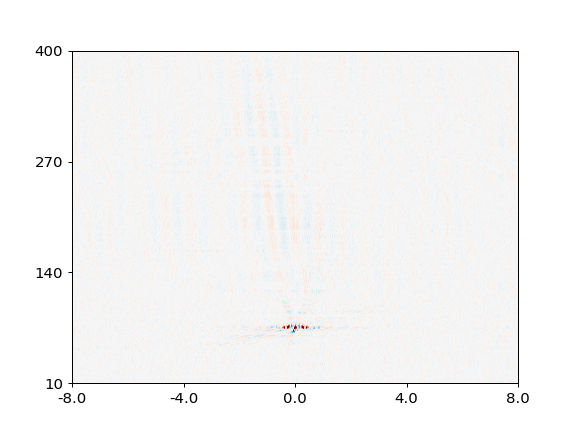

In [1681]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

ims = []
fig = plt.figure()
for i in np.arange(0,nsta,1):
    vsg = np.zeros([801, nsta])
    source_step = i
    for i in range(source_step):
        chan_source = i + cha1
        iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
        vsg[:, i] = corr_full[:, iS + (source_step - i)][::-1]

    chan_source = cha1 + source_step
    iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
    iS2 =  int((cha2*2 - cha1 - (chan_source+1) + 1) * ((chan_source+1) - cha1) / 2)
    vsg[:, source_step:] = corr_full[:, iS:iS2]
    
    im = plt.imshow(vsg.T, aspect = 'auto', cmap = 'RdBu', 
               vmax = 5e-2, vmin = -5e-2, origin = 'lower')

    _ = plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
                  [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
    _ = plt.xticks(np.arange(0, 801, 200), (np.arange(0, 801, 200) - 400)/50, fontsize = 12)
    
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=500)

writer = PillowWriter(fps=20)
#ani.save("../Figures/move_out_land_dec.gif", writer=writer)

plt.show()

## 5.2 FFT

## 5.2.1 FFT of specific channel

<IPython.core.display.Javascript object>


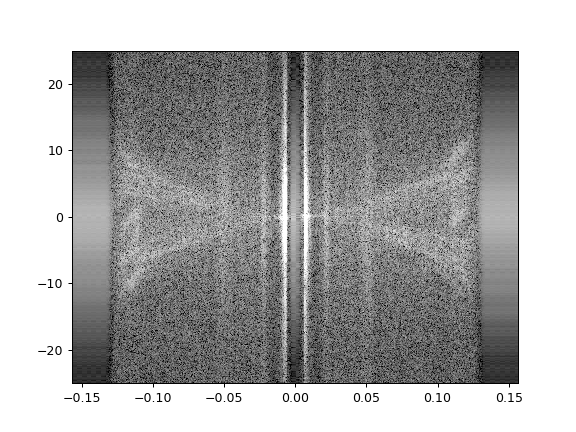

In [2111]:
from numpy.fft import fftshift, fft2, fftfreq

source_step = 100
chan_source = cha1 + source_step #choose the virtual source channel


vsg = np.zeros([801, nsta])
for i in range(source_step):
    chan_source = i + cha1
    iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
    vsg[:, i] = corr_full[:, iS + (source_step - i)][::-1]
chan_source = cha1 + source_step
iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
iS2 =  int((cha2*2 - cha1 - (chan_source+1) + 1) * ((chan_source+1) - cha1) / 2)
vsg[:, source_step:] = corr_full[:, iS:iS2]

ft = fftshift(fft2(vsg.T))
f = fftshift(fftfreq(vsg.T.shape[0], d=1/samp_freq))
k = fftshift(fftfreq(vsg.T.shape[1], d=attrs['SpatialSamplingInterval']))

fig, ax = plt.subplots()
# ax.imshow(np.real(ft), aspect = 'auto', cmap = 'RdBu', 
#            vmax = 1e0, vmin = -1e0, origin = 'lower')

ax.pcolormesh(k,f,np.log10(np.abs(ft)),vmin=-1,vmax = 1, cmap='gray')
# ax.set_ylim([200,400])
# ax.set_xlim([300,500])
plt.show()

<IPython.core.display.Javascript object>


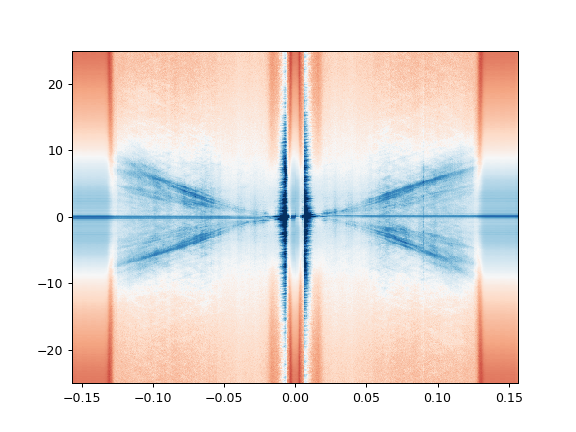

In [2112]:
all_ffts = []

for i in range(nsta):
    vsg = np.zeros([801, nsta])
    source_step = i
    for i in range(source_step):
        chan_source = i + cha1
        iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
        vsg[:, i] = corr_full[:, iS + (source_step - i)][::-1]

    chan_source = cha1 + source_step
    iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
    iS2 =  int((cha2*2 - cha1 - (chan_source+1) + 1) * ((chan_source+1) - cha1) / 2)
    vsg[:, source_step:] = corr_full[:, iS:iS2]
    source_step = i


    ft = fftshift(fft2(vsg.T))
    f = fftshift(fftfreq(vsg.T.shape[0], d=1/samp_freq))
    k = fftshift(fftfreq(vsg.T.shape[1], d=attrs['SpatialSamplingInterval']))
#     print(ft.shape)
    all_ffts.append(np.log10(np.abs(ft)))
    
d3_matrix = np.asarray(all_ffts)
stacked = np.mean(d3_matrix, axis=0)


fig, ax = plt.subplots()

ax.pcolormesh(k,f,stacked,vmin=-1,vmax = 1, cmap='RdBu')
# ax.set_ylim([0,2])
# ax.set_xlim([0.006,.03])
plt.show()

# 5.2.2 Can we plot this as a dispersion curve in frequency-velocity space

In [2294]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

all_lags = []
all_lags_filtered = []
for i in np.arange(0,nsta,1):
    vsg = np.zeros([801, nsta])
    source_step = i
    for i in range(source_step):
        chan_source = i + cha1
        iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
        vsg[:, i] = corr_full[:, iS + (source_step - i)][::-1]

    chan_source = cha1 + source_step
    iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
    iS2 =  int((cha2*2 - cha1 - (chan_source+1) + 1) * ((chan_source+1) - cha1) / 2)
    vsg[:, source_step:] = corr_full[:, iS:iS2]
    
    ft = fftshift(fft2(vsg.T))
    f = fftshift(fftfreq(vsg.T.shape[0], d=1/samp_freq))
    k = fftshift(fftfreq(vsg.T.shape[1], d=attrs['SpatialSamplingInterval']))
    
    mask = np.zeros(ft.shape)
    mask[:,int(0.7*ft.shape[-1]):] = 1
    
    ifft = scipy.fft.ifft2(ft*mask)
    all_lags.append(vsg)
    all_lags_filtered.append(np.real(ifft).T)

<IPython.core.display.Javascript object>


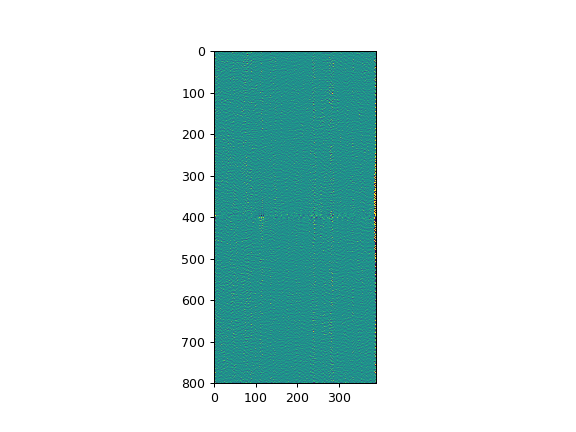

In [2293]:
#what is the mask doing?

mask = np.zeros(ft.shape)
mask[:,int(0.7*ft.shape[-1]):] = 1

ifft = scipy.fft.ifft2(ft*mask)
fig,ax=plt.subplots()
#ax.imshow(stacked*mask,vmin=-1e-5,vmax=1e-5)
ax.imshow(np.real(ifft).T,vmin=-1e-3,vmax=1e-3)
#ax.imshow(all_lags[-1],vmin=-1e-1,vmax=1e-1)

In [2170]:
# 1-D fft from the offsets
virtual_source_chan = 100
fft_offsets = fftshift(scipy.fft.fft(all_lags[virtual_source_chan], axis=0))
# fig,ax=plt.subplots()

# ax.imshow(np.real(fft_offsets))

In [2065]:
f_pos = f[int(0.5*len(f)):]
fft_offsets_pos = fft_offsets[:,int(0.5*fft_offsets.shape[-1]):]

x_k = (cha_list - virtual_source_chan)*cha_spacing
x_k = scipy.signal.resample(x_k, len(f_pos))

In [2066]:
poss_vel = np.arange(50,500,5)

fv = []
for i in poss_vel:
    phase_shift = (2*np.pi*f_pos*x_k)/i
    phase_weighted = np.real(fft_offsets_pos)*phase_shift
    phase_weighted_summed = np.sum(phase_weighted, axis=0)
    fv.append(phase_weighted_summed)
fv = np.asarray(np.real(fv))
# fv_pos = fv[:,int(0.5*fv.shape[-1]):]

<IPython.core.display.Javascript object>


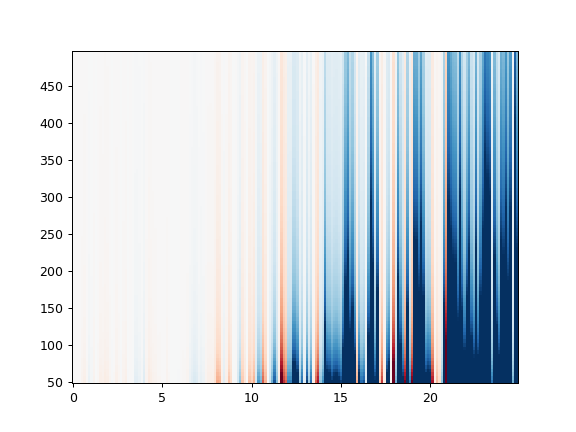

In [2068]:
# fig,ax = plt.subplots()
# ax.pcolormesh(f[int(0.5*len(f)):],poss_vel,fv_pos,vmin=-1e3,vmax = 1e3, cmap='RdBu')

fig,ax = plt.subplots()
ax.pcolormesh(f_pos, poss_vel,fv,vmin=-1e3,vmax = 1e3, cmap='RdBu')

<IPython.core.display.Javascript object>


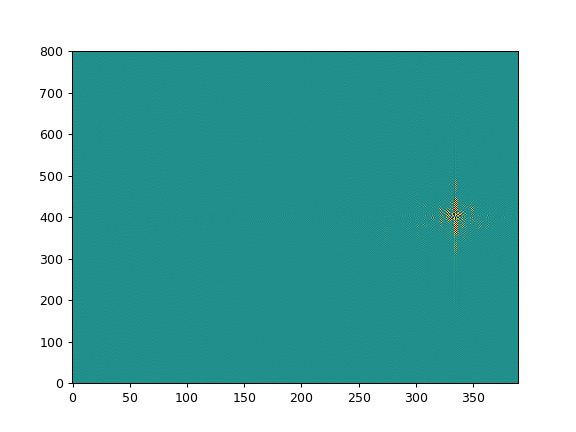

In [2295]:
ims_filt = []
fig = plt.figure()
for i in all_lags_filtered:
    im = plt.imshow(i, aspect = 'auto', 
               vmin=-1e-2,vmax=1e-2, origin = 'lower')

#     _ = plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
#                   [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
#     _ = plt.xticks(np.arange(0, 801, 200), (np.arange(0, 801, 200) - 400)/50, fontsize = 12)
    
    ims_filt.append([im])
    
ani = animation.ArtistAnimation(fig, ims_filt, interval=50, blit=True,
                                repeat_delay=500)

writer = PillowWriter(fps=20)
#ani.save("../Figures/move_out_land_dec.gif", writer=writer)

plt.show()

In [2027]:
#Actually trying to get this to work.

In [2296]:
#Loads delta t 
virtual_source_chan = 0
[ m, n] = all_lags_filtered[virtual_source_chan].shape

#time series for next power of two
np2 = (m - 1).bit_length()
u = np.zeros((2**np2,n))
u[0:m,0:n]=all_lags_filtered[virtual_source_chan]


In [2297]:
# 1-D fft from the offsets

U = np.fft.fft(u, axis=0)

In [2298]:
#Nyquist frequency
fnyq = 1/(2*dt)
fvec = fnyq*(np.arange(0,(2**(np2-1))+1,1))/(2**(np2-1))


fmini=min(np.argwhere(abs(fvec-fmin)<1))
fmaxi=min(np.argwhere(abs(fvec-fmax)<1))

In [2299]:
vrmin = 50
vrmax = 500
vrinc = 5
dx  = attrs['SpatialSamplingInterval']
dt = 1/fs
xo = 0
t=np.array(range(len(all_lags_filtered[virtual_source_chan])))*dt

In [2300]:
Vtrial = np.arange(vrmin, vrmax+vrinc, vrinc)
fi = np.arange(fmini, fmaxi+1)

V = np.zeros((len(Vtrial),len(fi)),dtype=complex)
xnf = 0
for i in fi :
    xnf += 1
    keq = (2*math.pi*fvec[i])/Vtrial
    for j in range(len(U[1])):
        e = np.exp(1j*keq*abs(j)*dx+xo)
        V[:,xnf-1]=V[:,xnf-1]+(U[i,j]/abs(U[i,j]))*e

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in cdouble_scalars
  # This is added back by InteractiveShellApp.init_path()


In [2301]:
normalized=1
if normalized==1:
    [tmpm, tmpn]=V.shape
    for im in range(tmpn):
        V[:,im]=V[:,im]/max(abs(V[:,im]))
ffi = fvec[fi]

fgrid, vgrid = np.meshgrid(ffi, Vtrial)
V=abs(V)

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


<IPython.core.display.Javascript object>


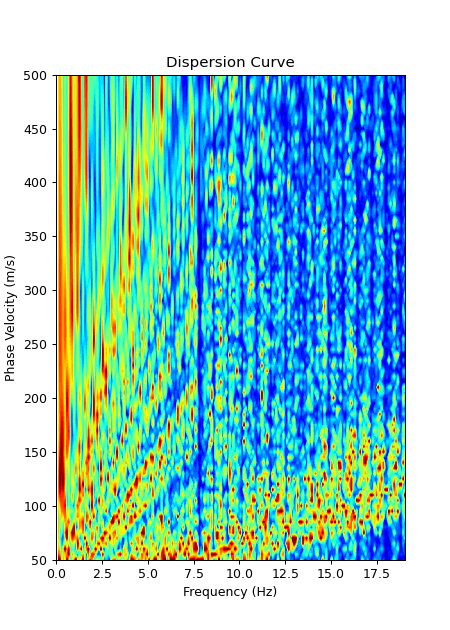

Text(0.5, 1.0, 'Dispersion Curve')

In [2302]:
fig=plt.figure(figsize=(5,7))

ax2 = fig.add_subplot(111)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase Velocity (m/s)')
plt.contourf(fgrid, vgrid, V,50, cmap='jet')
plt.title('Dispersion Curve')
# fig.savefig('PhaseShift.png',bbox_inches="tight",dpi=100)
# plt.close()

# 5.2.3 OK got it working for a single channel, now stack over all virtual sources

In [2120]:
# all_virtuals = []
# poss_vel = np.arange(50,500,5)

# for i in range(len(cha_list)):
#     # 1-D fft from the offsets
#     virtual_source_chan = i
#     fft_offsets = fftshift(scipy.fft.fft(all_lags[virtual_source_chan], axis=1))
#     f_pos = f[int(0.5*len(f)):]
#     fft_offsets_pos = fft_offsets[:,int(0.5*fft_offsets.shape[-1]):]

#     x_k = (cha_list - virtual_source_chan)*cha_spacing
#     x_k = scipy.signal.resample(x_k, len(f_pos))
#     fv = []
#     for i in poss_vel:
#         phase_shift = (2*np.pi*f_pos*x_k)/i
#         phase_weighted = np.real(fft_offsets_pos)*phase_shift
#         phase_weighted_summed = np.sum(phase_weighted, axis=0)
#         fv.append(phase_weighted_summed)
#     fv = np.asarray(np.real(fv))
#     all_virtuals.append(fv)
# all_virtuals = np.asarray(all_virtuals)
# all_virtuals_stacked = np.sum(all_virtuals, axis=0)
# fig,ax = plt.subplots()
# ax.pcolormesh(f_pos, poss_vel,all_virtuals_stacked,vmin=-1e3,vmax = 1e3, cmap='RdBu')

In [2129]:
vrmin = 50
vrmax = 500
vrinc = 5
dx  = attrs['SpatialSamplingInterval']
dt = 1/fs
xo = 0
t=np.array(range(len(all_lags[virtual_source_chan])))*dt

In [2130]:
all_sources = []
for i in range(len(cha_list)):
    #Loads delta t 
    virtual_source_chan = i
    [ m, n] = all_lags[virtual_source_chan].shape

    #time series for next power of two
    np2 = (m - 1).bit_length()
    u = np.zeros((2**np2,n))
    u[0:m,0:n]=all_lags[virtual_source_chan]
    
    # 1-D fft from the offsets

    U = np.fft.fft(u, axis=0)
    
    #Nyquist frequency
    fnyq = 1/(2*dt)
    fvec = fnyq*(np.arange(0,(2**(np2-1))+1,1))/(2**(np2-1))


    fmini=min(np.argwhere(abs(fvec-fmin)<1))
    fmaxi=min(np.argwhere(abs(fvec-fmax)<1))
    
    Vtrial = np.arange(vrmin, vrmax+vrinc, vrinc)
    fi = np.arange(fmini, fmaxi+1)

    V = np.zeros((len(Vtrial),len(fi)),dtype=complex)
    xnf = 0
    for i in fi :
        xnf += 1
        keq = (2*math.pi*fvec[i])/Vtrial
        for j in range(len(U[1])):
            e = np.exp(1j*keq*abs(j)*dx+xo)
            V[:,xnf-1]=V[:,xnf-1]+(U[i,j]/abs(U[i,j]))*e
            
    normalized=1
    if normalized==1:
        [tmpm, tmpn]=V.shape
        for im in range(tmpn):
            V[:,im]=V[:,im]/max(abs(V[:,im]))
    ffi = fvec[fi]

    fgrid, vgrid = np.meshgrid(ffi, Vtrial)
    V=abs(V)
    all_sources.append(V)

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


In [2132]:
all_sources_arr = np.asarray(all_sources)

In [2134]:
all_sources_arr = np.mean(all_sources_arr, axis=0)

<IPython.core.display.Javascript object>


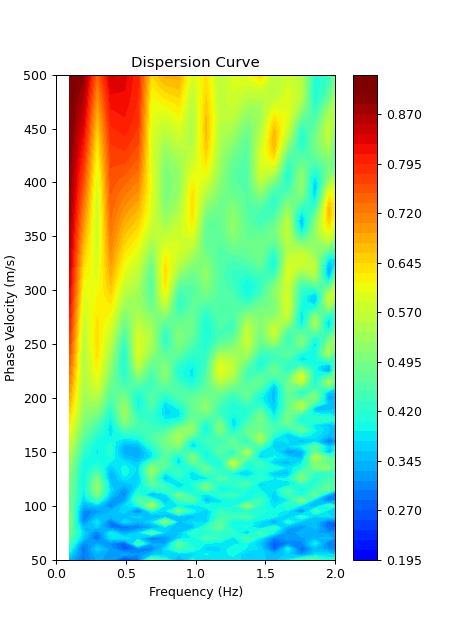

In [2141]:
fig=plt.figure(figsize=(5,7))

ax2 = fig.add_subplot(111)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase Velocity (m/s)')
plt.contourf(fgrid, vgrid, all_sources_arr,50, cmap='jet',vmin=0.1,vmax=.9)
plt.title('Dispersion Curve')
ax2.set_xlim([0,2])
plt.colorbar()
# fig.savefig('PhaseShift.png',bbox_inches="tight",dpi=100)
# plt.close()

In [2247]:
all_lags_filtered[virtual_source_chan][:,1].shape

(801,)

In [2303]:
vrmin = 50
vrmax = 500
vrinc = 5
dx  = attrs['SpatialSamplingInterval']
dt = 1/fs
xo = 0
t=np.array(range(len(all_lags[virtual_source_chan])))*dt

In [2304]:
all_sources_filtered = []
for i in range(len(cha_list)):
    #Loads delta t 
    virtual_source_chan = i
    [ m, n] = all_lags_filtered[virtual_source_chan].shape

    #time series for next power of two
    np2 = (m - 1).bit_length()
    u = np.zeros((2**np2,n))
    u[0:m,0:n]=all_lags_filtered[virtual_source_chan]
    
    # 1-D fft from the offsets

    U = np.fft.fft(u, axis=0)
    
    #Nyquist frequency
    fnyq = 1/(2*dt)
    fvec = fnyq*(np.arange(0,(2**(np2-1))+1,1))/(2**(np2-1))


    fmini=min(np.argwhere(abs(fvec-fmin)<1))
    fmaxi=min(np.argwhere(abs(fvec-fmax)<1))
    
    Vtrial = np.arange(vrmin, vrmax+vrinc, vrinc)
    fi = np.arange(fmini, fmaxi+1)

    V = np.zeros((len(Vtrial),len(fi)),dtype=complex)
    xnf = 0
    for i in fi :
        xnf += 1
        keq = (2*math.pi*fvec[i])/Vtrial
        for j in range(len(U[1])):
            e = np.exp(1j*keq*abs(j)*dx+xo)
            V[:,xnf-1]=V[:,xnf-1]+(U[i,j]/abs(U[i,j]))*e
            
    normalized=1
    if normalized==1:
        [tmpm, tmpn]=V.shape
        for im in range(tmpn):
            V[:,im]=V[:,im]/max(abs(V[:,im]))
    ffi = fvec[fi]

    fgrid, vgrid = np.meshgrid(ffi, Vtrial)
    V=abs(V)
    all_sources_filtered.append(V)

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in cdouble_scalars
/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in true_divide


In [2305]:
all_sources_arr_filt = np.asarray(all_sources_filtered)
all_sources_arr_filt = np.mean(all_sources_arr_filt, axis=0)

<IPython.core.display.Javascript object>


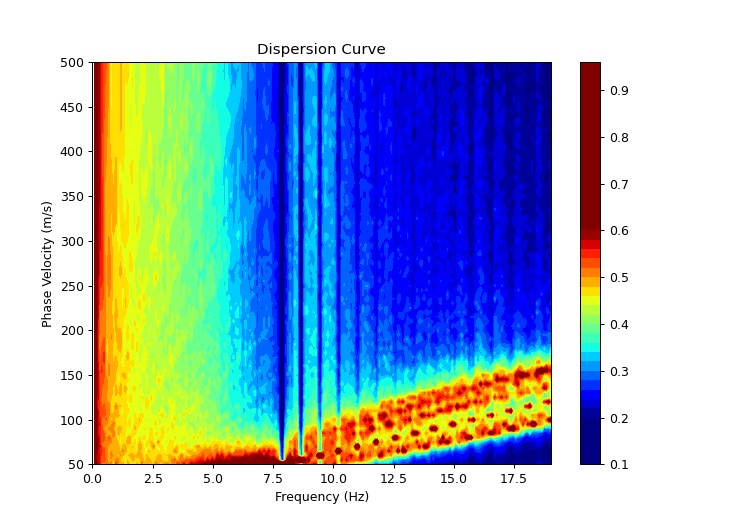

In [2323]:
fig=plt.figure(figsize=(5,7))

ax2 = fig.add_subplot(111)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Phase Velocity (m/s)')
plt.contourf(fgrid, vgrid, all_sources_arr_filt,50, cmap='jet',vmin=0.2,vmax=.6)
plt.title('Dispersion Curve')
#ax2.set_xlim([0,.2])
plt.colorbar()
# fig.savefig('PhaseShift.png',bbox_inches="tight",dpi=100)
# plt.close()

# 6.0 Implementing dv (or attempting to)

#### Maybe we do this by saving a reference FK plot and then calculating the difference between a new FK plot and the reference.

#### Peak detection of the wavespeed in the FK plot and find what the wavespeed is in the reference, and then see how that changes over time?

In [1552]:
#Slicing to get the top right quadrant

stacked_rows = stacked.shape[0]
stacked_cols = stacked.shape[1]

frow = f[int(stacked_rows*0.5):]
kcol = k[int(stacked_cols*0.6):int(stacked_cols*0.7)]

tr_quad = stacked[int(stacked_rows*0.5):,int(stacked_cols*0.6):int(stacked_cols*0.7)]

<IPython.core.display.Javascript object>


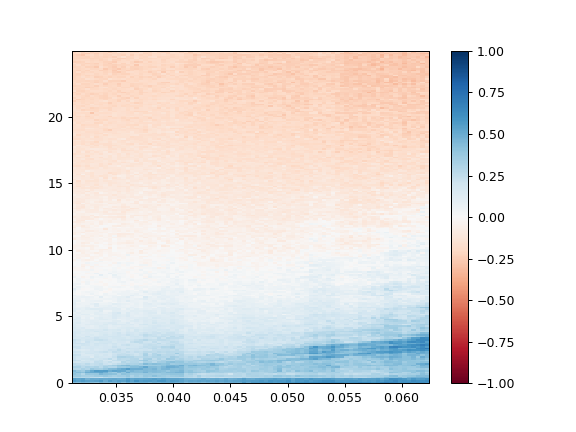

In [1553]:
#Plot what the upper right quadrant look likes

fig, ax = plt.subplots()

c = ax.pcolormesh(kcol,frow,tr_quad,vmin=-1,vmax = 1, cmap='RdBu')
plt.colorbar(c)
# ax.set_ylim([0,2])
# ax.set_xlim([0.006,.03])
plt.show()

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if __name__ == "__main__":


<IPython.core.display.Javascript object>


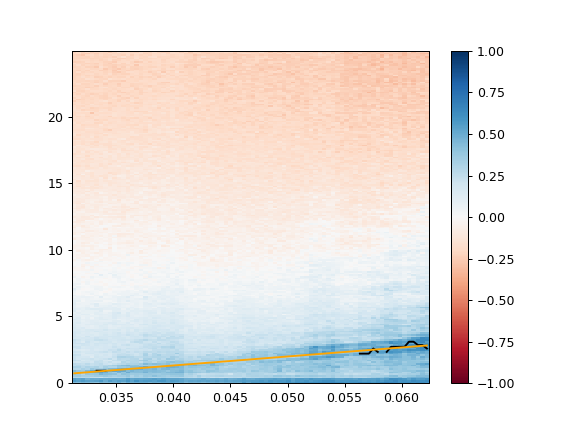

wave speed: 215.82328382812776


In [1589]:
from scipy.signal import find_peaks
import math

peaks = np.zeros((len(kcol)))

for i in range(len(kcol)):
    peak_loc, properties = find_peaks(tr_quad[:,i], prominence=.29)

    if not peak_loc:
        peaks[i] = np.nan
    else:
        peaks[i] = peak_loc

        

f_peaks = np.zeros((len(kcol)))  

for i, j in enumerate(np.asarray(peaks)):
        if math.isnan(j):
            f_peaks[i] = np.nan
        else:
            f_peaks[i] = frow[int(j)]

idx = np.isfinite(kcol) & np.isfinite(f_peaks)
ab = np.polyfit(kcol[idx], f_peaks[idx], 1)

fig, ax = plt.subplots()

c = ax.pcolormesh(kcol,frow,tr_quad,vmin=-1,vmax = 1, cmap='RdBu')
plt.colorbar(c)
ax.plot(kcol, f_peaks, color='black')
ax.plot(kcol,kcol*ab[0]+ab[-1], color='orange')
# ax.set_ylim([0,2])
# ax.set_xlim([0.006,.03])
plt.show()

wave_speed = ab[0] * attrs['SpatialSamplingInterval']
print('wave speed: '+ str(wave_speed))

## 6.1 Create dataframe and run this cell to create a new dict to add to existing 'wavespeeds' dataframe

In [1542]:
# Run only the first time

wavespeeds = pd.DataFrame(data_for_dataframe)

In [1557]:
data_for_dataframe = {'Wavespeed': [wave_speed], 'Time':[str(file_start_time)], 'Duration (min)':[n_minute]}

In [1581]:
wavespeeds

Wavespeed                 Time  Duration (min)
0  211.207449  2022-12-01 02:00:00             120
1  215.537300  2022-12-01 02:00:00             120

## 6.2 Append dataframe here

In [1558]:
to_append = pd.DataFrame(data_for_dataframe)
wavespeeds = pd.concat([wavespeeds, to_append], ignore_index=True)
print(wavespeeds)

    Wavespeed                 Time  Duration (min)
0  211.207449  2022-12-01 02:00:00             120
1  215.537300  2022-12-01 02:00:00             120


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [1496]:
# data_for_dataframe = {'Wavespeed': [235.645769], 'Time':['2022-11-24 02:00:00'], 'Duration (min)':[120]}

# 7.0 Feature extraction

## 7.1 Get the data

In [1262]:
cab = 'whidbey'
this_id = None
event_df = None
t0 = datetime(2023, 1, 18, 11, 0, 0)
record_length = 120


data, times, attrs, x_max, this_id, data_filt, t0 = das_downloader(event_df, this_id, cab, t0 = t0, record_length = record_length)

# start and end channel index for the sub-array
# cha1, cha2 = 0, attrs[ 'NumberOfLoci'] #all channels
cha1, cha2 = 1100, 1600 #some channels
cha_spacing = attrs['SpatialSamplingInterval']





/data/data6/whidbey/whidbey_2023-01-18_11-00*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-01*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-02*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-03*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-04*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-05*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-06*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-07*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-08*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-09*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-10*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-11*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-12*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-13*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-14*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-15*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-16*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-17*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-18*.h5
/data/data6/whidbey/whidbey_2023-01-18_11-19*.h5
/data/data6/whidbey/

In [ ]:
# Plot the data
plt.figure(figsize = (10, 5), dpi = 100)
plt.imshow(data_filt[:,cha1:cha2].T, aspect = 'auto', 
           cmap = 'RdBu', vmax = 1.5e1, vmin = -1.5e1, origin='lower')
_ =plt.yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
plt.ylabel("Channel number", fontsize = 15)
plt.xlabel("Time", fontsize = 15)
twiny = plt.gca().twinx()
twiny.set_yticks(np.linspace(0, cha2 - cha1, 4), 
                             [int(i* cha_spacing) for i in np.linspace(cha1, cha2, 4)])
twiny.set_ylabel("Distance along cable (m)", fontsize = 15)
plt.colorbar(pad = 0.1)

## 7.2 Pre-process the data

In [1263]:
detrended = scipy.signal.detrend(data[:,cha1:cha2].T, axis=1)

# fig,ax = plt.subplots()

# ax.imshow(detrended, aspect='auto', vmin=-1, vmax =1)

In [1264]:
#taper

window = scipy.signal.tukey(detrended.shape[-1], alpha=0.7)
taper = detrended * window

# fig,ax = plt.subplots()
# ax.imshow(taper, aspect='auto', vmin=-1, vmax =1)

In [1385]:
nmax

720000

In [1265]:
# Filtering
freqs = [[.001, .01],[.01, .1],[.1, 2]]
datas = []
for i in freqs:
    low_cut = i[0]
    hi_cut = i[1]
    

    b,a = scipy.signal.butter(2,[low_cut,hi_cut],'bp',fs=attrs['MaximumFrequency']*2,output='ba')
    data_filt = scipy.signal.filtfilt(b,a,taper,axis=1)
    datas.append(data_filt)

In [1233]:
# sliced=datas[1]
# fig,ax = plt.subplots()
# ax.imshow(sliced, aspect='auto', vmin=-np.percentile(sliced,99), vmax =np.percentile(sliced,99))

In [1266]:
fs=attrs['PulseRate']
wlen = int(6 * 60 * fs)
nmax = int(wlen*np.floor(data.shape[0]/wlen))

In [1300]:
empty_list = []

In [1321]:
for i in range(datas[2].shape[0]):
    datas_rsam = seis_feature.RSAM(datas[2][i], fs, empty_list, freqs[0], nmax, wlen) # get RSAM for different frequency bands

<IPython.core.display.Javascript object>


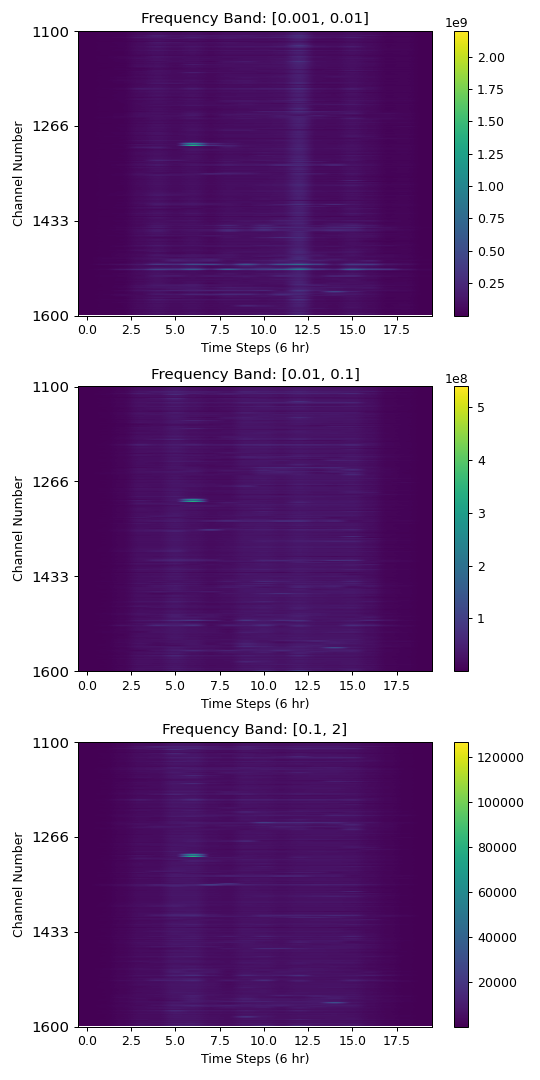

In [1387]:

fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=[6,12])
#ax.plot(np.asarray(empty_list).T)
im1 = ax1.imshow(np.asarray(empty_list[0:500]), aspect='auto')
ax1.set_ylabel('Channel Number')
ax1.set_xlabel('Time Steps (6 hr)')
ax1.set_title('Frequency Band: '+str(freqs[0]))

im2 = ax2.imshow(np.asarray(empty_list[500:1000]), aspect='auto')
ax2.set_ylabel('Channel Number')
ax2.set_xlabel('Time Steps (6 hr)')
ax2.set_title('Frequency Band: '+str(freqs[1]))

im3 = ax3.imshow(np.asarray(empty_list[1000:1500]), aspect='auto')
ax3.set_ylabel('Channel Number')
ax3.set_xlabel('Time Steps (6 hr)')
ax3.set_title('Frequency Band: '+str(freqs[2]))
_ =ax1.set_yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
_ =ax2.set_yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)
_ =ax3.set_yticks(np.linspace(cha1, cha2, 4) - cha1, 
              [int(i) for i in np.linspace(cha1, cha2, 4)], fontsize = 12)



fig.colorbar(im1, ax=ax1, orientation='vertical')
fig.colorbar(im2, ax=ax2, orientation='vertical')
fig.colorbar(im3, ax=ax3, orientation='vertical')
plt.tight_layout()
plt.show()

198
698
1198


<IPython.core.display.Javascript object>


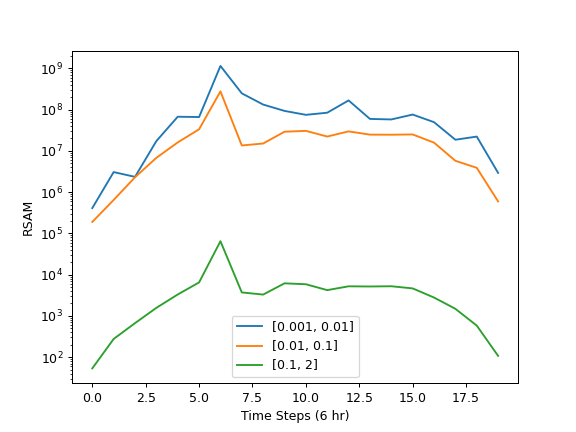

In [1390]:
one_channel_freqs = []

start, stop, step = 198,1500,500
for i in np.arange(start,stop,step):
    print(i)
    one_channel_freqs.append(empty_list[i])

fig,ax = plt.subplots()
#ax.plot(np.asarray(empty_list).T)
ax.plot(np.asarray(one_channel_freqs).T[:,0], label=str(freqs[0]))
ax.plot(np.asarray(one_channel_freqs).T[:,1], label=str(freqs[1]))
ax.plot(np.asarray(one_channel_freqs).T[:,2], label=str(freqs[2]))
ax.set_ylabel('RSAM')
ax.set_xlabel('Time Steps (6 hr)')
plt.yscale('log')
plt.legend()
plt.show()

In [1352]:
np.asarray(datas).shape

(3, 500, 720000)